# 필요한 라이브러리 호출

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 1. 데이터 준비하기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### 데이터 확인해 보기

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

# 2. 데이터 전처리

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 테스트셋에도 똑같이 작업을 합니다.

### 하지만 테스트셋에는 타겟데이터인 price가 없기 때문에 price처리는 하지 않습니다.

In [5]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# 방의 개수에 대한 가격을 살펴보겠습니다.

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

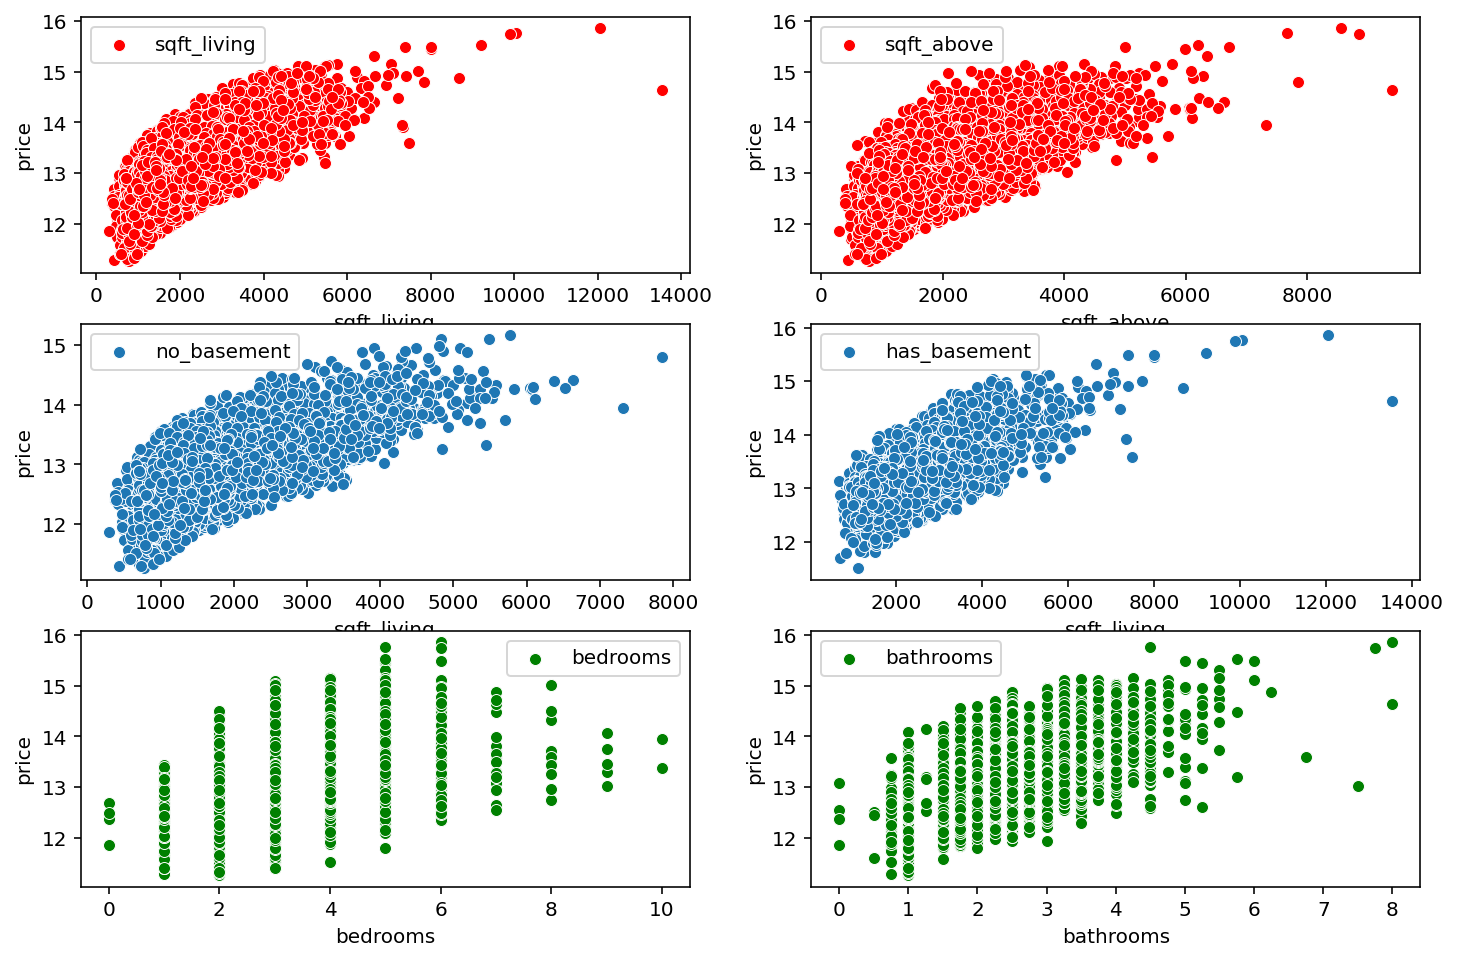

In [6]:
fig, axes = plt.subplots(nrows=3, ncols = 2)
fig.set_size_inches(12,8)

sns.scatterplot(x=train.sqft_living, y=np.log(train.price), ax = axes[0][0], color = 'red', label = "sqft_living")
sns.scatterplot(x=train.sqft_above, y=np.log(train.price), ax = axes[0][1], color = 'red', label = "sqft_above")
sns.scatterplot(x= train[train.sqft_basement == 0].sqft_living, y= np.log(train.price), ax=axes[1][0], label = "no_basement")
sns.scatterplot(x= train[train.sqft_basement != 0].sqft_living, y= np.log(train.price), ax=axes[1][1], label = "has_basement")
sns.scatterplot(x=train.bedrooms, y=np.log(train.price), ax = axes[2][0], color = 'green', label = "bedrooms")
sns.scatterplot(x=train.bathrooms, y=np.log(train.price), ax = axes[2][1], color = 'green', label = "bathrooms")

### 어느정도 관계있는 지표 같습니다.

# 총 방의 개수와 집값을 살펴보겠습니다.

<AxesSubplot:xlabel='total_rooms', ylabel='price'>

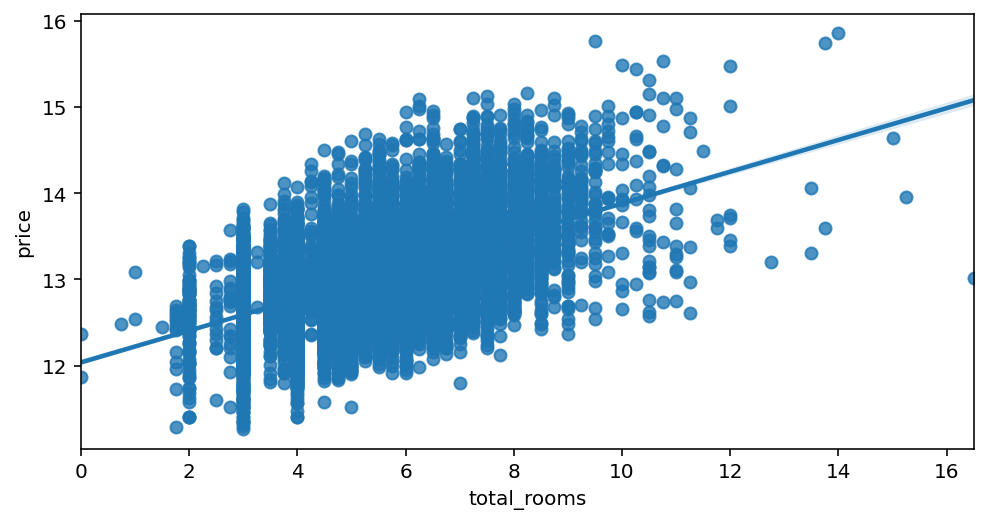

In [7]:
train['total_rooms'] = train['bedrooms'] + train['bathrooms']
test['total_rooms'] = test['bedrooms'] + test['bathrooms']

data = pd.concat([train['price'], train['total_rooms']], axis=1)
fig, axes = plt.subplots()
fig.set_size_inches(8,4)

sns.regplot(x=train.total_rooms, y=np.log(train.price), ax = axes, data=data)

### 어느 선형성이 있습니다.
### 제일 오른쪽 점은 이상치 같아 제거 하겠습니다.

In [8]:
train.loc[(train['total_rooms'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms
5990,5990,201408,450000.0,9,7.5,4050,6504,2.0,0,0,...,4050,0,1996,0,98144,47.5923,-122.301,1448,3866,16.5


In [9]:
train = train.loc[train['id'] != 5986]

## 평방피트를 합친 새로운 특징을 만들어 보겠습니다.

<AxesSubplot:xlabel='total_size', ylabel='price'>

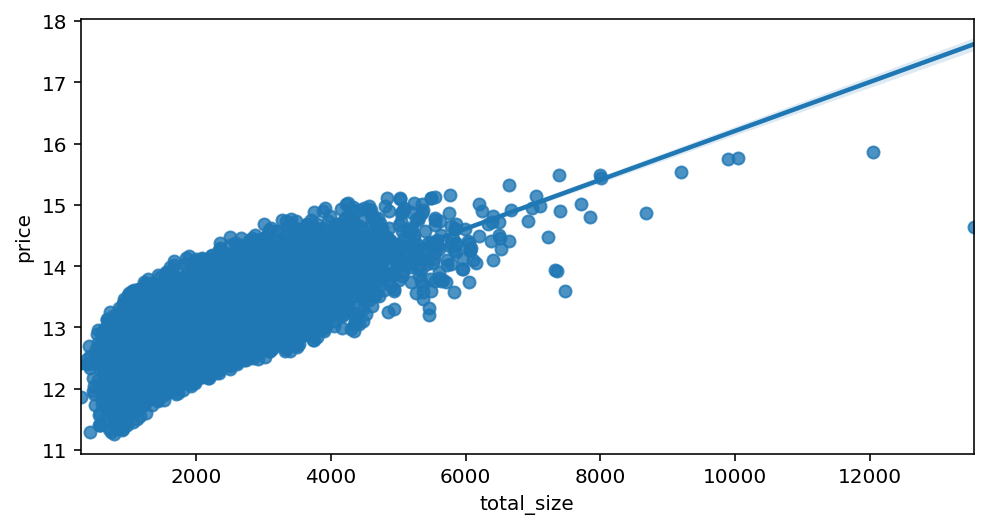

In [10]:
train['total_size'] = train['sqft_above'] + train['sqft_basement']
test['total_size'] = test['sqft_above'] + test['sqft_basement']

data = pd.concat([train['price'], train['total_size']], axis=1)
fig, axes = plt.subplots()
fig.set_size_inches(8,4)

sns.regplot(x=train.total_size, y=np.log(train.price), ax = axes, label = "total_size")

### 어느정도 선형성을 보이지만 이번에도 오른쪽점이 이상치 같아 제거하겠습니다.

In [11]:
train.loc[(train['total_size'] > 12300)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,total_size
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,...,4130,1999,0,98053,47.6675,-121.986,4850,217800,15.0,13540


In [12]:
train = train.loc[train['id'] != 8912]

# 집을 지은 년도와 재건축 년도와 상관관계를 보겠습니다.

<AxesSubplot:xlabel='yr_renovated', ylabel='price'>

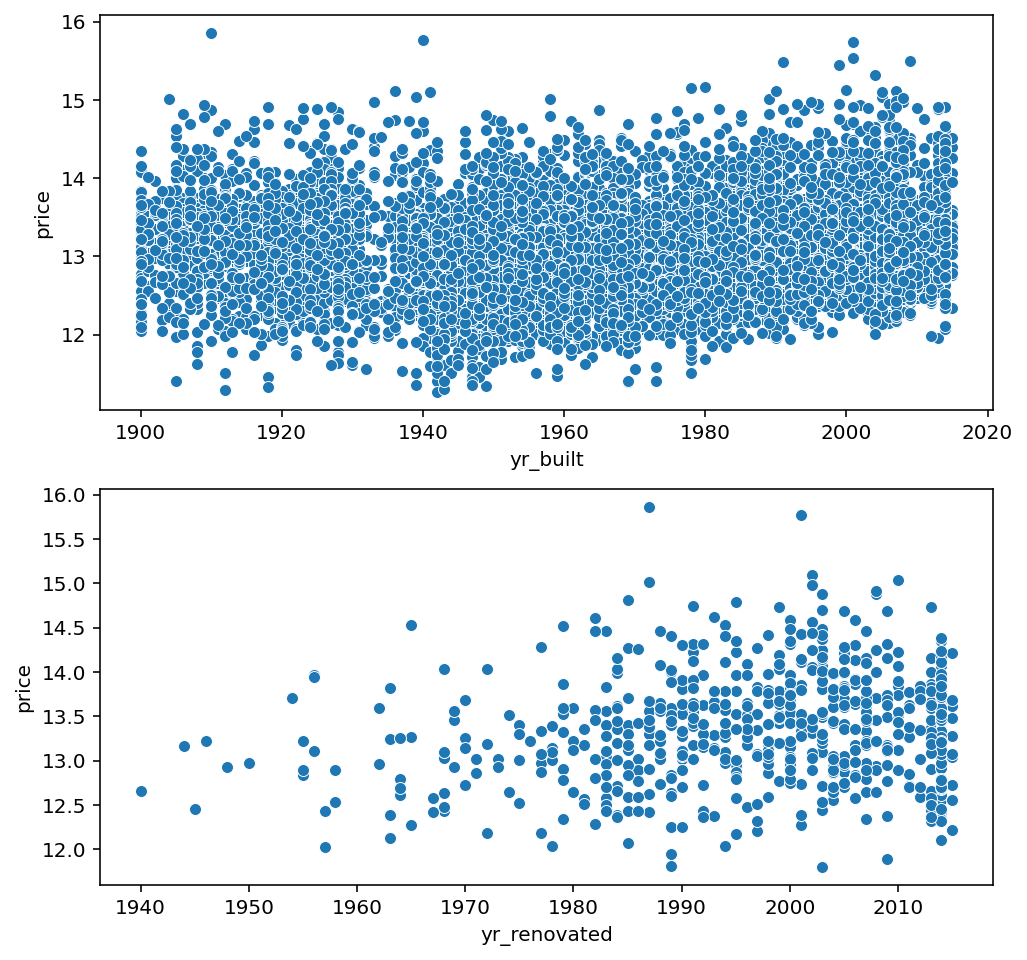

In [13]:
fig, axes = plt.subplots(nrows = 2)
fig.set_size_inches(8,8)

sns.scatterplot(x=train.yr_built, y=np.log(train.price), ax = axes[0])
sns.scatterplot(x=train[train.yr_renovated != 0].yr_renovated, y=np.log(train[train.yr_renovated != 0].price), ax = axes[1])

### 관련이 없어 보여 두 변수를 모두 제거 하겠습니다.

In [14]:
del train['yr_built']
del train['yr_renovated']

del test['yr_built']
del test['yr_renovated']

## view와 waterfront를 살펴보겠습니다.

<AxesSubplot:xlabel='waterfront', ylabel='price'>

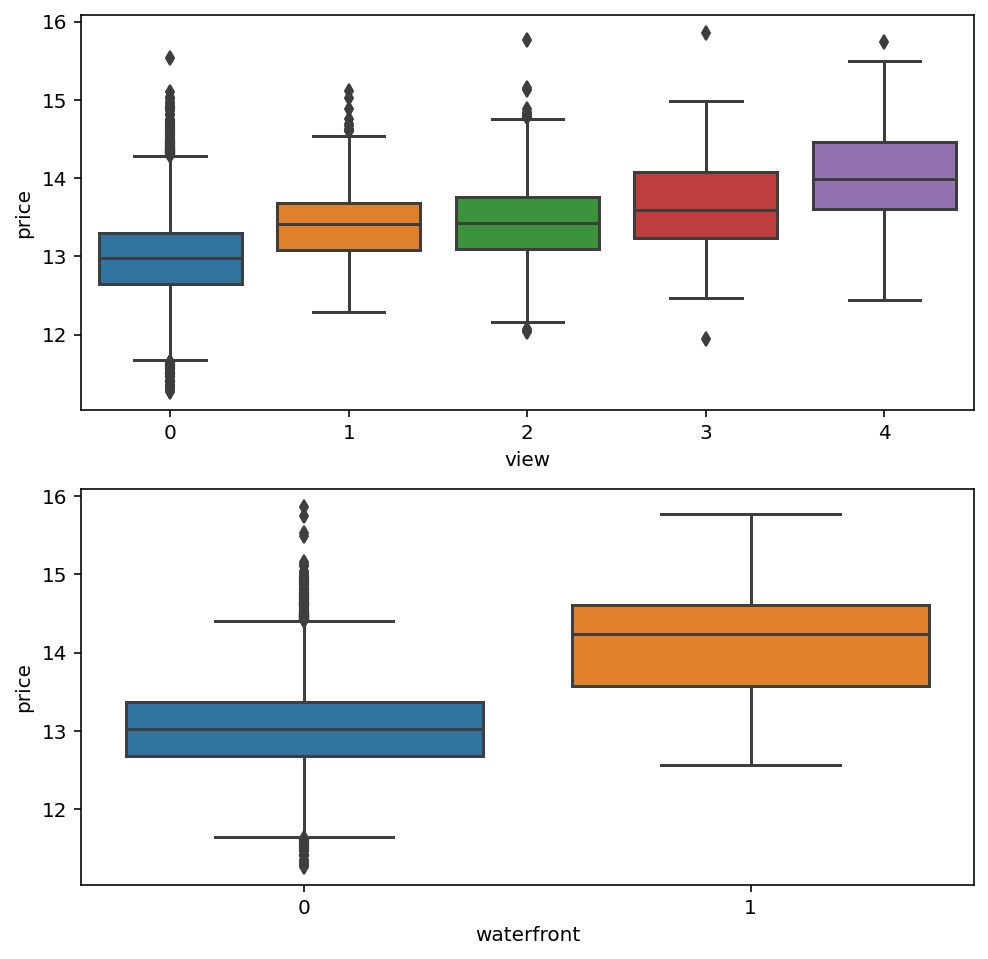

In [15]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(8,8)
sns.boxplot(x=train.view , y= np.log(train.price), ax = axes[0])
sns.boxplot(x=train.waterfront, y=np.log(train.price), ax = axes[1])

### 어느정도 올라갈수록 가격이 올라가지만, 이상치를 모두 제거하기엔 너무 많아 일단 냅두겠습니다.

## grade를 살펴보겠습니다.

<AxesSubplot:xlabel='grade', ylabel='price'>

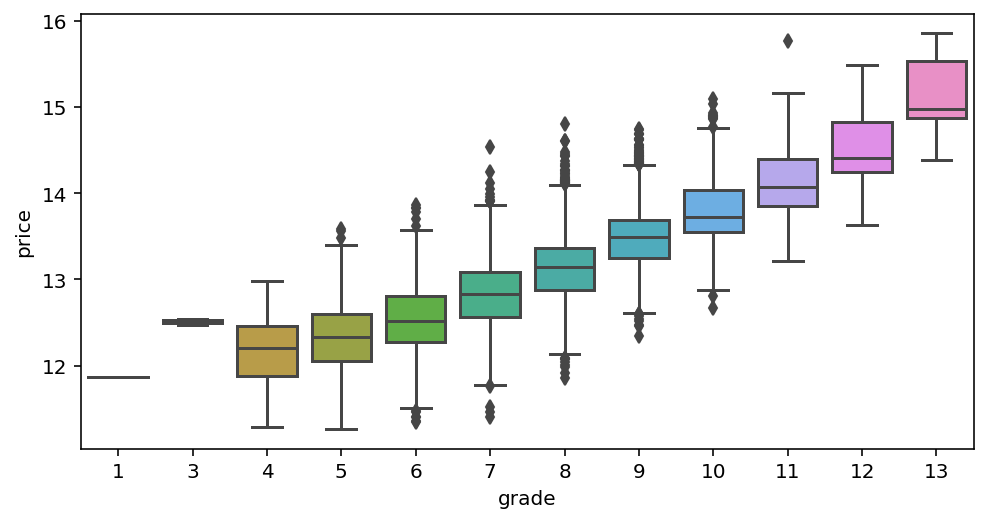

In [16]:
plt.figure(figsize = (8,4))
sns.boxplot(x = train.grade , y=np.log(train.price))

### 3, 7, 8, 11 에서 튀어나온게 있어 확인해보겠습니다.

In [17]:
train.loc[(train['grade'] <= 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,total_size
2302,2302,201502,262000.0,1,0.75,520,12981,1.0,0,0,...,3,520,0,98022,47.2082,-121.995,1340,12233,1.75,520
4123,4123,201411,280000.0,1,0.00,600,24501,1.0,0,0,...,3,600,0,98045,47.5316,-121.749,990,22549,1.00,600
13522,13522,201409,142000.0,0,0.00,290,20875,1.0,0,0,...,1,290,0,98024,47.5308,-121.888,1620,22850,0.00,290


### 3이하는 3개 밖에 없어 다 제거하겠습니다.

In [18]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 13522]

### 7의 이상치 1개도 제거하겠습니다.

In [19]:
train.loc[(np.log(train['price']) > 14.3) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,total_size
12346,12346,201501,2050000.0,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,98125,47.7087,-122.276,2410,6389,7.25,3580


In [20]:
train = train.loc[train['id'] != 12346]

### 8의 이상치도 3개 제거하겠습니다.

In [21]:
train.loc[(np.log(train['price']) > 14.5) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,total_size
983,983,201505,2200000.0,5,4.25,4640,22703,2.0,1,4,...,8,2860,1780,98052,47.6393,-122.097,3140,14200,9.25,4640
7173,7173,201408,2700000.0,5,4.00,4230,27295,2.0,1,4,...,8,3230,1000,98033,47.6803,-122.214,2660,27295,9.00,4230
10037,10037,201408,2200000.0,3,2.00,3570,30456,1.0,0,1,...,8,2070,1500,98039,47.6413,-122.240,3570,27418,5.00,3570


In [22]:
train = train.loc[train['id'] != 983]
train = train.loc[train['id'] != 7173]
train = train.loc[train['id'] != 10037]

# 11의 이상치 1개도 제거하겠습니다.

In [23]:
train.loc[(np.log(train['price']) > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,total_size
2775,2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,98004,47.65,-122.214,3930,25449,9.5,10040


In [24]:
train = train.loc[train['id'] != 2775]

## 다시 한번 출력해 보겠습니다.

<AxesSubplot:xlabel='grade', ylabel='price'>

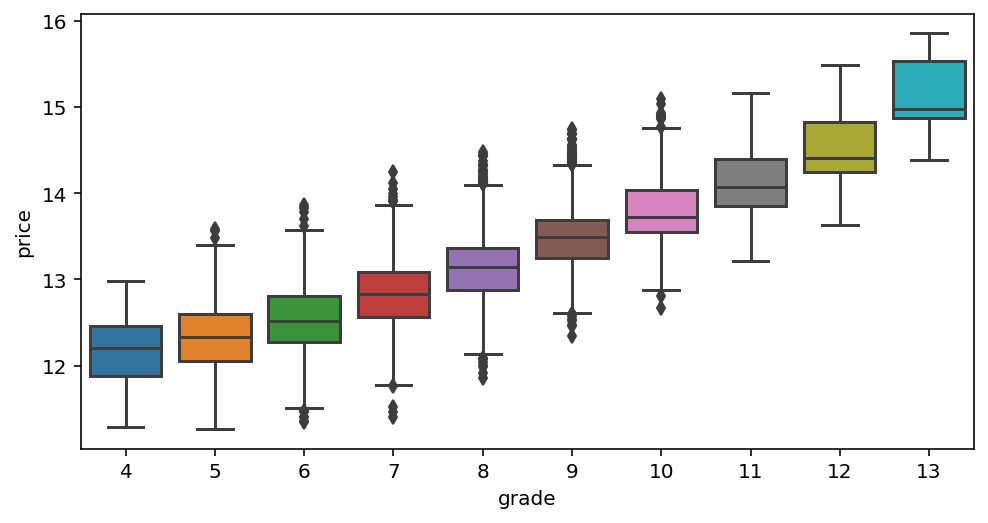

In [25]:
plt.figure(figsize = (8,4))
sns.boxplot(x = train.grade , y=np.log(train.price))

# 주소에 대한 평균 집값

In [26]:
zipsum = train[['zipcode','sqft_lot']].groupby('zipcode', as_index = False).sum() 
zipcount = train[['zipcode','price']].groupby('zipcode', as_index=False).sum()
zip_avg = pd.merge(zipsum, zipcount, on='zipcode')
zip_avg['zip_avg_price'] = zip_avg['price'] / zip_avg['sqft_lot'] 

train = pd.merge(train, zip_avg[['zipcode','zip_avg_price']], on ='zipcode', how='left')
test =  pd.merge(test,  zip_avg[['zipcode','zip_avg_price']], on ='zipcode', how='left')

In [27]:
train['zipvalue'] =  train['zip_avg_price']*train['sqft_lot']
test['zipvalue'] =  test['zip_avg_price']*test['sqft_lot']

In [28]:
zip_mean = train[['zipcode','price']].groupby('zipcode', as_index=False).mean()
zip_mean.rename(columns={'price':'zip_avg_house_price'}, inplace=True)
train = pd.merge(train, zip_mean[['zipcode','zip_avg_house_price']], on ='zipcode', how='left')
test = pd.merge(test, zip_mean[['zipcode','zip_avg_house_price']], on ='zipcode', how='left')

<AxesSubplot:xlabel='zipvalue', ylabel='price'>

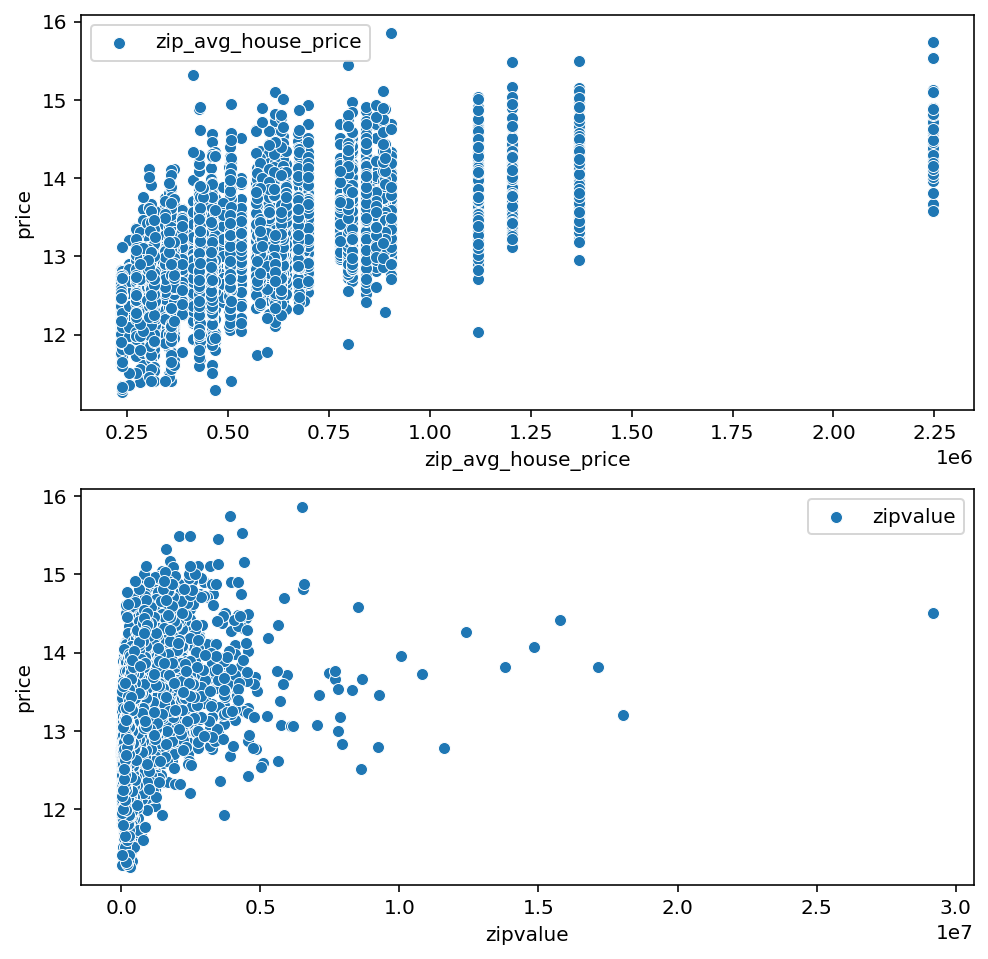

In [29]:
fig, axes = plt.subplots(nrows =2)
fig.set_size_inches(8,8)

sns.scatterplot(x=train.zip_avg_house_price, y=np.log(train.price), ax = axes[0], label = "zip_avg_house_price")
sns.scatterplot(x=train.zipvalue, y=np.log(train.price), ax = axes[1], label = "zipvalue")

## 거실의 크기를 비율로 바꿔보겠습니다.

<AxesSubplot:xlabel='ratio15', ylabel='price'>

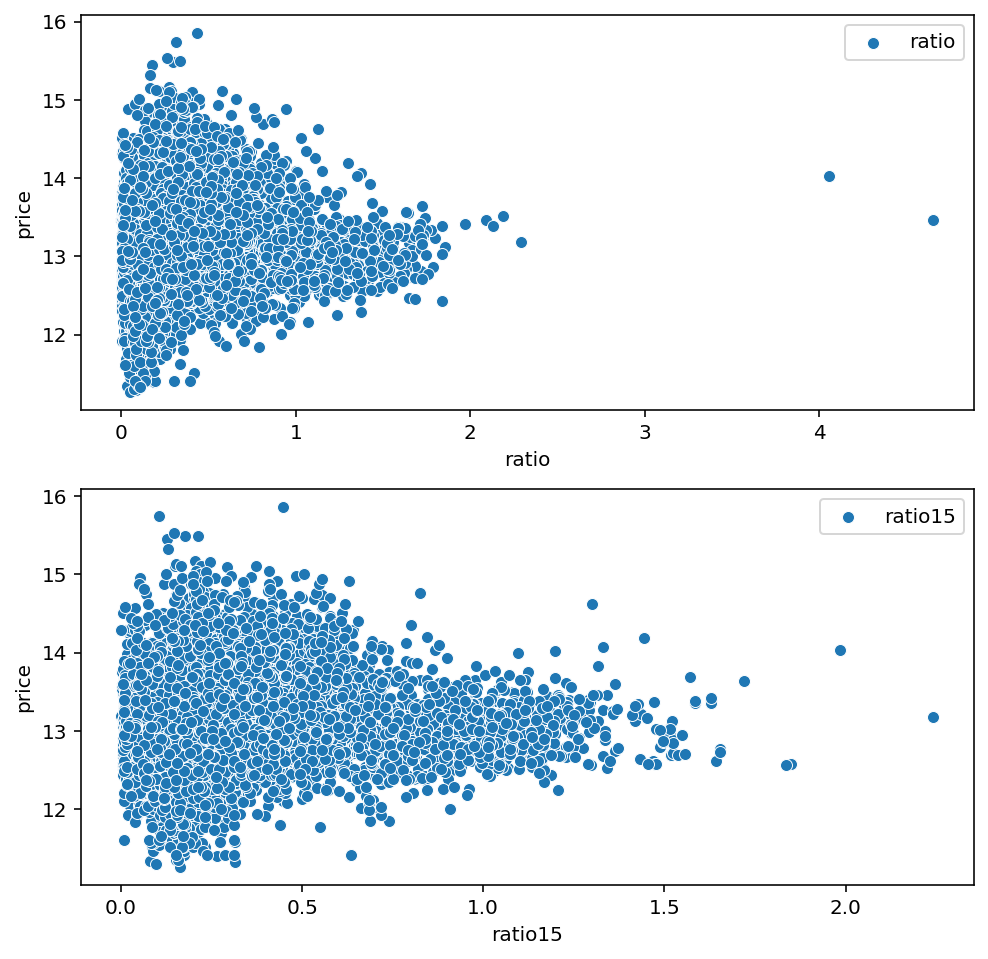

In [30]:
train['ratio'] = train['sqft_living'] / train['sqft_lot']
test['ratio'] = test['sqft_living'] / test['sqft_lot']
train['ratio15'] = train['sqft_living15'] / train['sqft_lot15']
test['ratio15'] = test['sqft_living15'] / test['sqft_lot15']

fig, axes = plt.subplots(nrows =2)
fig.set_size_inches(8,8)

sns.scatterplot(x=train.ratio, y=np.log(train.price), ax = axes[0], label = "ratio")
sns.scatterplot(x=train.ratio15, y=np.log(train.price), ax = axes[1], label = "ratio15")

# 이제 y값에 price를 저장하겠습니다.

In [31]:
y = train['price']

print(train.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'total_size',
       'zip_avg_price', 'zipvalue', 'zip_avg_house_price', 'ratio', 'ratio15'],
      dtype='object')


# 한쪽으로 치우져 있네요

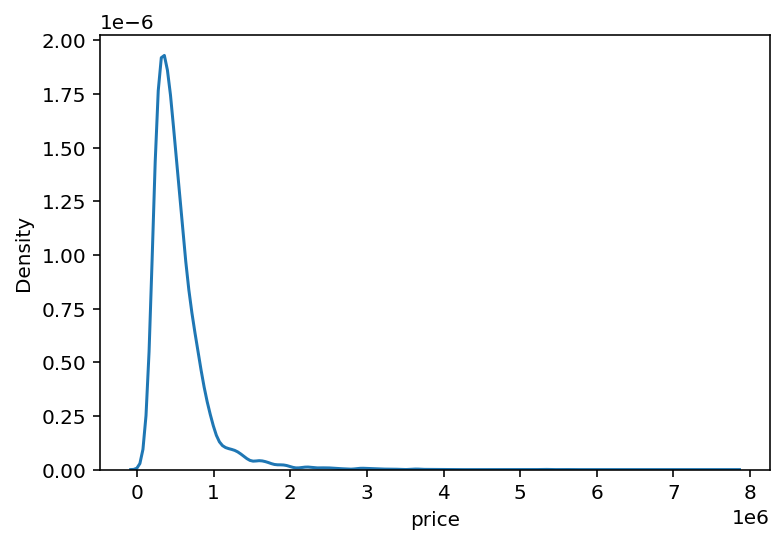

In [32]:
sns.kdeplot(y)
plt.show()

# log를 취해 완만하게 만들겠습니다.

In [33]:
y = np.log1p(y)

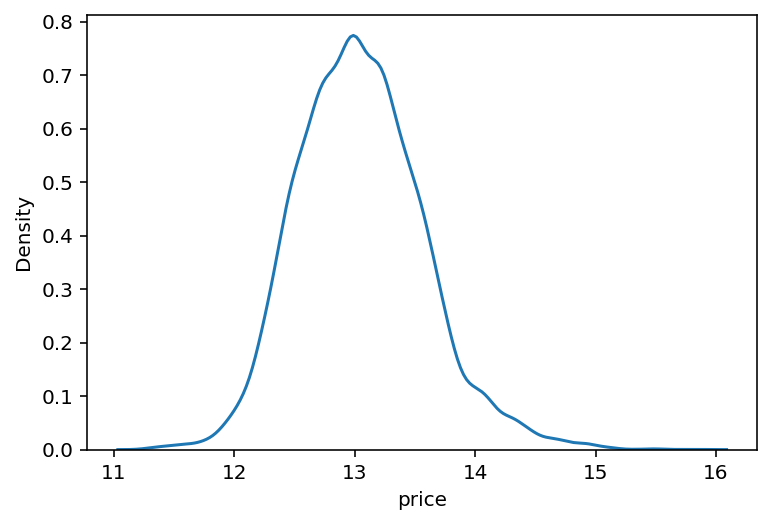

In [34]:
sns.kdeplot(y)
plt.show()

### 전체 데이터 자료형을 보겠습니다.

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15025 entries, 0 to 15024
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15025 non-null  int64  
 1   date                 15025 non-null  int64  
 2   price                15025 non-null  float64
 3   bedrooms             15025 non-null  int64  
 4   bathrooms            15025 non-null  float64
 5   sqft_living          15025 non-null  int64  
 6   sqft_lot             15025 non-null  int64  
 7   floors               15025 non-null  float64
 8   waterfront           15025 non-null  int64  
 9   view                 15025 non-null  int64  
 10  condition            15025 non-null  int64  
 11  grade                15025 non-null  int64  
 12  sqft_above           15025 non-null  int64  
 13  sqft_basement        15025 non-null  int64  
 14  zipcode              15025 non-null  int64  
 15  lat                  15025 non-null 

# 이제 필요 없는 id와 train의 price를 제거하겠습니다.

In [36]:
del train['price']
del train['id']

del test['id']

### 출력해보겠습니다.

In [37]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,total_rooms,total_size,zip_avg_price,zipvalue,zip_avg_house_price,ratio,ratio15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,-122.257,1340,5650,4.00,1180,37.105667,209647.021175,308083.718750,0.208850,0.237168
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,-122.233,2720,8062,3.00,770,40.747809,407478.089943,460595.393035,0.077000,0.337385
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,-122.045,1800,7503,5.00,1680,48.540018,392203.343859,697933.386441,0.207921,0.239904
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,-122.327,2238,6819,5.25,1715,26.938842,183695.962435,288215.610811,0.251503,0.328201
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,-122.315,1650,9711,4.50,1060,28.545547,277205.811152,304198.797980,0.109155,0.169910


In [38]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,total_rooms,total_size,zip_avg_price,zipvalue,zip_avg_house_price,ratio,ratio15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,...,-122.319,1690,7639,5.25,2570,58.990356,4.272082e+05,458397.146758,0.354874,0.221233
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,...,-122.393,1360,5000,7.00,1960,92.166318,4.608316e+05,568012.262570,0.392000,0.272000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,...,-122.005,4760,101930,8.50,5420,18.786577,1.914916e+06,674190.371025,0.053174,0.046699
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,...,-122.337,1780,8113,4.00,1780,40.305067,3.010789e+05,357876.115789,0.238286,0.219401
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,...,-122.031,2390,7570,5.50,1890,14.856698,9.745994e+04,364934.488095,0.288110,0.315720


# 3. RMSE 계산

### RMSE는 Root Mean Squared Error 의 약자이며, 이는 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근입니다.

### RMSE를 계산하는 함수를 만들어보겠습니다.

In [39]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 앞에서 로그함수로 그래프를 완만하게 만들었기 때문에 np.expm1함수로 돌려줍니다.

In [40]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=5        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 각 모델의 이름은 __name__속성으로 접근 가능합니다.

In [41]:
gboost.__class__.__name__

'GradientBoostingRegressor'

# for 문을 사용해 각 모델별로 학습 및 예측이 가능합니다.

In [42]:
df = {}
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 114777.22944815198,
 'XGBRegressor': 113992.3480672602,
 'LGBMRegressor': 107977.71770834884,
 'RandomForestRegressor': 121212.43943243266}

# 위의 코드를 사용해 함수로 바꿔보겠습니다.

In [43]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

,RMSE
RandomForestRegressor,121212.439432
GradientBoostingRegressor,114777.229448
XGBRegressor,113992.348067
LGBMRegressor,107977.717708


# LGBMRegressor 점수가 가장 좋아보이니 이 모델로 학습해보겠습니다.

# 4. 모델 설계

### 하이퍼 파라미터를 여러 값을 저장한 후 그리드 탐색으로 가장 좋은 파라미터를 탐색해보겠습니다.

In [44]:
param_grid = {
    'n_estimators': [100, 1000, 2000],
    'max_depth': [1, 10],
    'learning_rate' : [0.01, 0.05],
    'boosting' : ['goss', 'gbdt']
}

In [45]:
model =  LGBMRegressor(random_state=random_state)

In [46]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   50.4s
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:  2.7min finished


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=5), n_jobs=5,
             param_grid={'boosting': ['goss', 'gbdt'],
                         'learning_rate': [0.01, 0.05], 'max_depth': [1, 10],
                         'n_estimators': [100, 1000, 2000]},
             scoring='neg_mean_squared_error', verbose=1)

In [47]:
grid_model.cv_results_

{'mean_fit_time': array([ 0.43064814,  2.82631202,  4.92944765,  1.60897303, 10.5035285 ,
        19.83118148,  0.40074039,  2.95907574,  5.46102986,  1.24549751,
         9.80281696, 19.48844943,  0.31317387,  2.15256472,  4.26746287,
         1.30845613, 10.27276192, 17.58825102,  0.28540921,  2.21445885,
         4.35048585,  1.28977776,  8.10233488, 14.53903446]),
 'std_fit_time': array([0.114469  , 0.62957078, 0.79374873, 0.34792675, 1.67687432,
        2.9250039 , 0.07990573, 0.60729999, 0.91347579, 0.29969437,
        1.11150735, 1.91896202, 0.01819041, 0.45614812, 0.42354298,
        0.15606349, 1.76523594, 2.53919573, 0.00303735, 0.29406391,
        0.7163635 , 0.18692631, 1.49603266, 1.05210056]),
 'mean_score_time': array([0.0166029 , 0.1974503 , 0.3498395 , 0.04353728, 0.81716814,
        1.69183588, 0.01889124, 0.23907895, 0.35810461, 0.0889029 ,
        0.94639354, 1.73498673, 0.02329192, 0.17939992, 0.42705474,
        0.05181251, 0.77103434, 1.47545304, 0.01437869, 0.23

In [48]:
params = grid_model.cv_results_['params']
params

[{'boosting': 'goss',
  'learning_rate': 0.01,
  'max_depth': 1,
  'n_estimators': 100},
 {'boosting': 'goss',
  'learning_rate': 0.01,
  'max_depth': 1,
  'n_estimators': 1000},
 {'boosting': 'goss',
  'learning_rate': 0.01,
  'max_depth': 1,
  'n_estimators': 2000},
 {'boosting': 'goss',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 100},
 {'boosting': 'goss',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 1000},
 {'boosting': 'goss',
  'learning_rate': 0.01,
  'max_depth': 10,
  'n_estimators': 2000},
 {'boosting': 'goss',
  'learning_rate': 0.05,
  'max_depth': 1,
  'n_estimators': 100},
 {'boosting': 'goss',
  'learning_rate': 0.05,
  'max_depth': 1,
  'n_estimators': 1000},
 {'boosting': 'goss',
  'learning_rate': 0.05,
  'max_depth': 1,
  'n_estimators': 2000},
 {'boosting': 'goss',
  'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 100},
 {'boosting': 'goss',
  'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 1000},
 {'boosti

In [49]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.15685339, -0.039364  , -0.03417589, -0.07681647, -0.02676292,
       -0.02644815, -0.0547853 , -0.03113593, -0.03002433, -0.02861223,
       -0.02767761, -0.02843654, -0.15685339, -0.0403103 , -0.03477835,
       -0.07681647, -0.0271779 , -0.02664318, -0.05610722, -0.03189305,
       -0.03069377, -0.02889252, -0.02698292, -0.02754324])

In [50]:
results = pd.DataFrame(params)
results['score'] = score

results

,boosting,learning_rate,max_depth,n_estimators,score
0,goss,0.01,1,100,-0.156853
1,goss,0.01,1,1000,-0.039364
2,goss,0.01,1,2000,-0.034176
3,goss,0.01,10,100,-0.076816
4,goss,0.01,10,1000,-0.026763
5,goss,0.01,10,2000,-0.026448
6,goss,0.05,1,100,-0.054785
7,goss,0.05,1,1000,-0.031136
8,goss,0.05,1,2000,-0.030024
9,goss,0.05,10,100,-0.028612


### 스코어값으로 RMSE를 계산한뒤 옆에 붙여보겠습니다.

In [51]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,boosting,learning_rate,max_depth,n_estimators,score,RMSE
0,goss,0.01,1,100,-0.156853,0.396047
1,goss,0.01,1,1000,-0.039364,0.198404
2,goss,0.01,1,2000,-0.034176,0.184867
3,goss,0.01,10,100,-0.076816,0.277158
4,goss,0.01,10,1000,-0.026763,0.163594
5,goss,0.01,10,2000,-0.026448,0.162629
6,goss,0.05,1,100,-0.054785,0.234063
7,goss,0.05,1,1000,-0.031136,0.176454
8,goss,0.05,1,2000,-0.030024,0.173275
9,goss,0.05,10,100,-0.028612,0.169151


### 스코어 값이 -이기 때문에 변환해줬습니다.

In [52]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
0,goss,0.01,1,100,-0.156853,0.396047
1,goss,0.01,1,1000,-0.039364,0.198404
2,goss,0.01,1,2000,-0.034176,0.184867
3,goss,0.01,10,100,-0.076816,0.277158
4,goss,0.01,10,1000,-0.026763,0.163594
5,goss,0.01,10,2000,-0.026448,0.162629
6,goss,0.05,1,100,-0.054785,0.234063
7,goss,0.05,1,1000,-0.031136,0.176454
8,goss,0.05,1,2000,-0.030024,0.173275
9,goss,0.05,10,100,-0.028612,0.169151


### 정렬해 보겠습니다.

In [53]:
results = results.sort_values('RMSLE')
results

,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
5,goss,0.01,10,2000,-0.026448,0.162629
17,gbdt,0.01,10,2000,-0.026643,0.163227
4,goss,0.01,10,1000,-0.026763,0.163594
22,gbdt,0.05,10,1000,-0.026983,0.164265
16,gbdt,0.01,10,1000,-0.027178,0.164857
23,gbdt,0.05,10,2000,-0.027543,0.165962
10,goss,0.05,10,1000,-0.027678,0.166366
11,goss,0.05,10,2000,-0.028437,0.168631
9,goss,0.05,10,100,-0.028612,0.169151
21,gbdt,0.05,10,100,-0.028893,0.169978


# 위 코드들을 하나의 함수로 바꿔보겠습니다.

In [54]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [55]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [56]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0222')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0222.csv saved!


![image](https://user-images.githubusercontent.com/84653776/137862211-2f98cb97-9ff4-446a-819a-e6ea0c744bd5.png)

# 회고

### 점수를 110000점 이하로 낮추기는 실패했습니다.

### 처음엔 하이퍼파라미터만 바꿔서 해보았지만 너무 탐색할게 많고 점수가 일정이하로 잘 떨어지지 않아서 다른 특징을 잡아 데이터에 포함하는것을 캐글 대회 홈페이지에서 많이 참고했습니다.

### 여러 데이터를 만들고 가격과 큰 영향이 있는지 판단해 가며 추가하고 삭제하고 여러 시도를 해보았습니다.

### 조금 의외였던건 위에서는 date를 넣었는데 솔직히 상관 없다고 생각해서 처음엔 빼고 했지만 점수가 오히려 안좋아졌습니다.

### 또, 집을 지은 년도와 재건축 년도도 상관 없어보여 위에서는 제거 했지만 사실 포함 했을 때 점수가 더 높았습니다.

### 마지막으로 price와 관련된 특징을 새로 만들때, test셋은 price값이 없어서 어떻게 추가하나 고민하다 구글링으로 좋은방법을 알게되었습니다.

### 꼭 데이터가 선형이여야 결과가 잘 나오는건 아니라는 것을 알았고, 하이퍼파라미터의 중요성도 알게 되었습니다.